In [671]:
# Importing Functions and Libraries
import sys

# Add the directory containing your modules to the Python path
module_path = r"c:\Users\grayd\OneDrive - Colorado School of Mines\Desktop\Mines 2024-2025 Senior\CFD\416 ryan"
if module_path not in sys.path:
    sys.path.append(module_path)
import numpy as np

from matplotlib import pyplot
from Derivatives import FiniteDifference_2D, FiniteDifference_2D_single

from GhostCells import Ghost_Cells
from TimeStep import Time_Step
from Equations_State import EquationOfState



In [672]:
#Parameters
dim     = 2         # Number of dimensions 2D, but for primative and conserved variables 4 equns
                    # [continuity, momentum_x, momentum_y, energy]
                    # In primative currently [rho, u, v, e + kinetic energy]
                    # In conserved currently [rho*u, rho*u*u + P, rho*u*v, E]

Nx      = 100       # Number of Nodes  
Ny      = 100       # Number of Nodes     

x_start = 0         # Physical X Start
x_end   = 2*np.pi   # Physical X End

y_start = 0         # Physical Y Start
y_end   = 2*np.pi   # Physical Y End

order   = 4         # Order for derivatives
t_start = 0         # Start time
t_end   = 5         # End time
iter_end = 100000

CFL     = 0.1       # Courant-Friedrichs-Lewy number

# Re, Ma and L
Re      = 75              # Reynolds number
Ma      = 0.2               # Mach number
L_0     = 2*np.pi           # Length scale in m

# Inital Pressure Temperature
P_0     = 100000            # Initial pressure in Pa
T_0     = 300               # Initial temperature in K

# Gas Properties
R_u     = 8.31446261815324  # Universal gas constant in J/(mol·K)
m_air   = 28.96/1000        # Molar mass of dry air in kg/mol
gamma   = 7.0/5.0           # Ratio of specific heats
R_s     = R_u/m_air         # Specific gas constant in J/(kg·K)

V_0     = Ma * np.sqrt(gamma * R_s * T_0)  # Velocity in m/s

rho_0   = P_0/(R_s*T_0)     # Initial density in kg/m^3, from ideal gas
mu      = rho_0*V_0*L_0/Re  # kg/m^1/s
Sc      = 0.006                 # Schmidt number
D       = rho_0/mu / Sc 
Pr      = 0.71              # Prandtl number
C_v     = R_s / (gamma-1)   
C_p     = R_s + C_v         # Specific heat capacity at constant pressure in J/(kg·K)
kappa   = mu * C_p / Pr     # Thermal conductivity in W/(m·K)

print(mu)
print(D)
plot_time = [0,0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.9, 1,1.1,1.2]    # Plot times
#plot_time = [0.01, 0.02]    # Plot times



6.755137249285707
28.64558461624193


In [673]:
# Basic Calculations Setting Up
# Secondary Parameters
ngc         = Ghost_Cells.number_ghost_cells(order)

dx          = (x_end - x_start) / Nx # mesh resolution
dy          = (y_end - y_start) / Ny # mesh resolution

x           = np.linspace(x_start + dx/2 - ngc*dx , x_end - dx/2 + ngc*dx, Nx + 2*ngc) # Range x values with ghost cells and fluid domain
y           = np.linspace(y_start + dy/2 - ngc*dy , y_end - dy/2 + ngc*dy, Ny + 2*ngc) # Range y values with ghost cells and fluid domain

X, Z        = np.meshgrid(x, y)    #For Contour Plotting

# Initalize Variables
V               = np.zeros((Nx + 2*ngc, Ny + 2*ngc, dim + 3))       # Primative Variables
                                                                    # density + 2 dim of velocity + energy
Q               = np.zeros((Nx + 2*ngc, Ny + 2*ngc, dim + 3))       # Conservative Variables
                                                                    # density + 2 dim of momentum + energy
P               = np.zeros((Nx + 2*ngc, Ny + 2*ngc))                # Pressure 
T               = np.zeros((Nx + 2*ngc, Ny + 2*ngc))                # Temperature                                                                               
                                                    
tau             = np.zeros((Nx + 2*ngc, Ny + 2*ngc, dim + 2))       # Stress Tensor
tau_xx          = np.zeros((Nx + 2*ngc, Ny + 2*ngc))
tau_yy          = np.zeros((Nx + 2*ngc, Ny + 2*ngc))
tau_xy          = np.zeros((Nx + 2*ngc, Ny + 2*ngc))
tau_yx          = np.zeros((Nx + 2*ngc, Ny + 2*ngc))
                                                            
Cx              = np.zeros((Nx + 2*ngc, Ny + 2*ngc, dim + 3))       # Convective flux x term
Cy              = np.zeros((Nx + 2*ngc, Ny + 2*ngc, dim + 3))       # Convective flux y term
Dx              = np.zeros((Nx + 2*ngc, Ny + 2*ngc, dim + 3))       # Diffusive flux x term
Dy              = np.zeros((Nx + 2*ngc, Ny + 2*ngc, dim + 3))       # Diffusive flux y term

e               = np.zeros((Nx + 2*ngc, Ny + 2*ngc))                # Internal Energy
vorticity       = np.zeros((Nx + 2*ngc, Ny + 2*ngc))                # Vorticity


# Y
# Y               = np.zeros((Nx + 2*ngc, Ny + 2*ngc))           # Mass Fraction

# #For left side

# mid_x = (Nx + 2*ngc) // 2  # half of the total y-size INCLUDING ghost cells
# Y[ngc:mid_x, ngc:-ngc] = np.exp(-X[ngc:mid_x, ngc:-ngc]**2 / 100)  # Y[0]

# # Top half assignment (Y2 dominates here)
# # If you want G[:,:,1] to be 1 - G[:,:,0] across the entire domain:
# Y[mid_x:-ngc, ngc:-ngc] = 1.0 - Y[ngc:mid_x, ngc:-ngc]    #Y[1]
# ngc = Ghost_Cells.number_ghost_cells(order)
# Y = Ghost_Cells.fill_ghost_cells_2D_single(Y, order)        

# print(Y[ngc:-ngc,ngc:-ngc])
# #print(Y[ngc:-ngc,ngc:-ngc,1])

# # print(Y.shape)


# Initalization of Y
Y = np.ones((Nx + 2*ngc, Ny + 2*ngc, 2))  # two species: Y[:,:,0] and Y[:,:,1]






In [674]:
def initial_condition_TGV(V, Y, V_0, P, P_0, rho_0, e, T, T_0, C_v, Nx, Ny, x, y, order):

    ngc = Ghost_Cells.number_ghost_cells(order)

    for i in range(Nx + 2*ngc):
        for j in range(Ny + 2*ngc):
            
            V[i,j,0]    = rho_0
            V[i,j,1]    =  V_0 * np.sin(x[i])*np.cos(y[j])                      # Velocity in x direction, u  I added two dont forget
            V[i,j,2]    = -V_0 * np.cos(x[i])*np.sin(y[j])                      # Velocity in y direction, intitialy 1 m/s, v
            
            P[i,j]      = P_0+(np.cos(2*x[i]) + np.cos(2*y[j]))*(rho_0/16.0)    # Pressure  
            T[i,j]      = T_0
            Y[i,j,0]    = (np.cos(x[i])**2 + np.sin(y[j])**2)/2.0  # Mass fraction of species 1, Y[0]
            # Y[i,j,0]    = (np.sin(x[i]) + 1.0 )/2.0
            Y[i,j,1]    = 1 - Y[i,j,0]
           
    e = EquationOfState.internal_energy_from_temperature(T, C_v, order)  # internal energy
    
    V[:,:,3] = e[:,:] + 0.5*(V[:,:,1]**2 + V[:,:,2]**2)                  # energy, e + 0.5*(u^2 + v^2)
    
    # fill gc here
    V = Ghost_Cells.fill_ghost_cells_2D(V, order)
    P = Ghost_Cells.fill_ghost_cells_2D_single(P, order)
    T = Ghost_Cells.fill_ghost_cells_2D_single(T, order)
    e = Ghost_Cells.fill_ghost_cells_2D_single(e, order)
    Y = Ghost_Cells.fill_ghost_cells_2D_single(Y, order)
    
    return V, P, T, e, Y
    

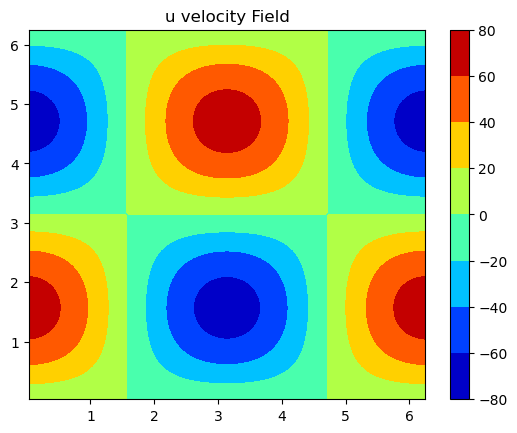

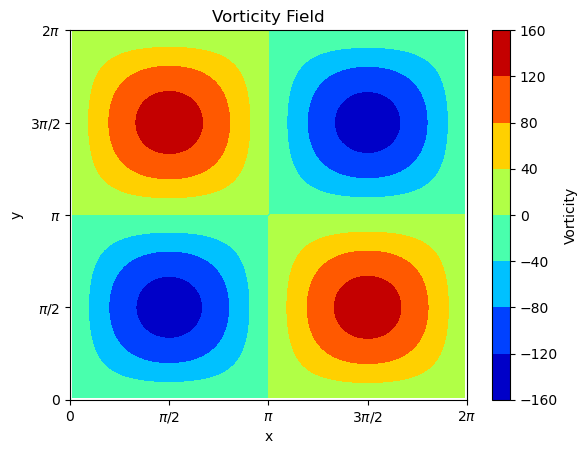

In [675]:
#
# # Check if the initial condition is correct:
# 
V, P, T, e, Y     = initial_condition_TGV(V, Y, V_0, P, P_0, rho_0, e, T, T_0, C_v, Nx, Ny, x, y, order)
X, Z        = np.meshgrid(x[ngc:-ngc], y[ngc:-ngc])
fig         = pyplot.figure()
ax1         = pyplot.contourf(X, Z, V[ngc:-ngc,ngc:-ngc,1])
pyplot.title('u velocity Field')

pyplot.colorbar()
pyplot.show()

dV_dx = FiniteDifference_2D.df_dx_2D(V, dx, order)
dV_dy = FiniteDifference_2D.df_dy_2D(V, dx, order)

# Initial Vorticity

vorticity = dV_dy[:,:,1] - dV_dx[:,:,2]  # Vorticity

# Plot the vorticity field
fig = pyplot.figure()
ax2 = pyplot.contourf(X, Z, vorticity[ngc:-ngc, ngc:-ngc])
pyplot.colorbar(ax2, label='Vorticity')
pyplot.xlabel('x')
pyplot.ylabel('y')

# Set x and y axis in terms of pi
xticks = np.arange(0, 2 * np.pi + np.pi / 2, np.pi / 2)
xtick_labels = ['0', '$\\pi/2$', '$\\pi$', '$3\\pi/2$', '$2\\pi$']
pyplot.xticks(xticks, xtick_labels)
pyplot.yticks(xticks, xtick_labels)

pyplot.title('Vorticity Field')
pyplot.show()



In [676]:
# calculate tau
def calculate_tau(tau, dV_dx, dV_dy, mu, order):
    # tau_xx = (2/3) * mu * (2 * du/dx - dv/dy)
    # tau_yy = (2/3) * mu * (2 * dv/dy - du/dx)
    # tau_xy = mu * (du/dy + dv/dx)
    # tau_yx = tau_xy
    
    tau[ngc:-ngc,ngc:-ngc,0] = (2.0/3.0) * mu * (2 * dV_dx[ngc:-ngc,ngc:-ngc,1] - dV_dy[ngc:-ngc,ngc:-ngc,2])
    tau[ngc:-ngc,ngc:-ngc,1] = (2.0/3.0) * mu * (2 * dV_dy[ngc:-ngc,ngc:-ngc,2] - dV_dx[ngc:-ngc,ngc:-ngc,1])
    tau[ngc:-ngc,ngc:-ngc,2] = mu * (dV_dy[ngc:-ngc,ngc:-ngc,1] + dV_dx[ngc:-ngc,ngc:-ngc,2])
    tau[ngc:-ngc,ngc:-ngc,3] = tau[ngc:-ngc,ngc:-ngc,2]
 
    #Fill ghost cells
    tau = Ghost_Cells.fill_ghost_cells_2D(tau, order)
    
    tau_xx = tau[:,:,0]
    tau_yy = tau[:,:,1]
    tau_xy = tau[:,:,2]
    tau_yx = tau[:,:,3]
    
    return tau, tau_xx, tau_yy, tau_xy, tau_yx

In [677]:
def get_Q_from_V(V, Q, order):
    # Q[0] = rho * Y[0]
    # Q[1] = rho*u
    # Q[2] = rho*v
    # Q[3] = E, rho*(e + 0.5*(u^2 + v^2))
    # Q[4] = rho * Y[1]
    Q[:,:,0] = V[:,:,0] * Y[:,:,0]
    Q[:,:,1] = V[:,:,0] * V[:,:,1] 
    Q[:,:,2] = V[:,:,0] * V[:,:,2]
    Q[:,:,3] = V[:,:,0] * V[:,:,3] 
    Q[:,:,4] = V[:,:,0] * Y[:,:,1]
    Q = Ghost_Cells.fill_ghost_cells_2D(Q, order)
    
    return Q 

In [678]:
def get_V_from_Q(Q, V, order):
    # V[0] = rho * Y[0] + rho * Y[1] gets total rho
    # V[1] = u
    # V[2] = v
    # V[3] = e + 0.5*(u^2 + v^2)
    # V[4] = rho
    V[:,:,0] = Q[:,:,0] + Q[:,:,4]
    #V[:,:,0] = np.where(V[:,:,0] == 0, 1e-10, V[:,:,0])  
    V[:,:,1] = Q[:,:,1] / V[:,:,0]
    V[:,:,2] = Q[:,:,2] / V[:,:,0]
    V[:,:,3] = Q[:,:,3]
    V[:,:,4] = V[:,:,0] 
    
    V = Ghost_Cells.fill_ghost_cells_2D(V, order)
    
    return V

In [679]:
def get_Convective_flux(V, Q, Cx, Cy, P, order):
    # Cx[0] = rho*u * Y[0]
    # Cx[1] = rho*u^2 + P
    # Cx[2] = rho*u*v
    # Cx[3] = E*u
    # Cx[4] = rho*u*Y[1]
    Cx[:,:,0] = Q[:,:,1] * Y[:,:,0]
    Cx[:,:,1] = Q[:,:,1]*V[:,:,1] + P[:,:]
    Cx[:,:,2] = Q[:,:,1]*V[:,:,2] 
    Cx[:,:,3] = (Q[:,:,3] + P[:,:])*V[:,:,1]
    Cx[:,:,4] = Q[:,:,1] * Y[:,:,1]
    # Cy[0] = rho*v * Y[0]
    # Cy[1] = rho*u*v
    # Cy[2] = rho*v^2 + P
    # Cy[3] = E*v
    # Cy[4] = rho*v*Y[1]
    Cy[:,:,0] = Q[:,:,2] * Y[:,:,0]
    Cy[:,:,1] = Q[:,:,1]*V[:,:,2]
    Cy[:,:,2] = Q[:,:,2]*V[:,:,2] + P[:,:]
    Cy[:,:,3] = (Q[:,:,3] + P[:,:])*V[:,:,2]
    Cy[:,:,4] = Q[:,:,2] * Y[:,:,1]
    
    # Fill ghost cells
    Cx = Ghost_Cells.fill_ghost_cells_2D(Cx, order)
    Cy = Ghost_Cells.fill_ghost_cells_2D(Cy, order)
    
    return Cx, Cy

In [680]:
def get_Diffusive_flux(V, Q, dT_dx, dT_dy, Dx, Dy, tau_xx, tau_yy, tau_xy, tau_yx, gamma, order):
    
    # Dx[0] = rho* D * Grad(Y[0]) 
    # Dx[1] = tau_xx
    # Dx[2] = tau_xy
    # Dx[3] = tau_xx*u + tau_xy*v + gamma*dT/dx
    # Dx[4] = rho * D * Grad(Y[1])
    Dx[:,:,0] =  V[:,:,0] * 1 * (FiniteDifference_2D_single.df_dx_2D(Y[:,:,0],dx,order))
    Dx[:,:,1] = tau_xx
    Dx[:,:,2] = tau_xy
    Dx[:,:,3] = tau_xx*V[:,:,1] + tau_xy*V[:,:,2] + kappa*dT_dx[:,:] \
                + C_p * T[:,:]  * V[:,:,0] * 1 * FiniteDifference_2D_single.df_dx_2D(Y[:,:,0],dx,order) \
                + C_p * T[:,:]  * V[:,:,0] * 1 * FiniteDifference_2D_single.df_dx_2D(Y[:,:,1],dx,order)
    Dx[:,:,4] = V[:,:,0] * D * (FiniteDifference_2D_single.df_dx_2D(Y[:,:,1],dx,order))
    # Dy[0] = rho* D * Grad(Y[0]) 
    # Dy[1] = tau_yx
    # Dy[2] = tau_yy
    # Dy[3] = tau_yx*u + tau_yy*v + gamma*dT/dy
    # Dy[4] = rho * D* * Grad(Y[1])
    Dy[:,:,0] = V[:,:,0] * 1 * (FiniteDifference_2D_single.df_dy_2D(Y[:,:,0], dy, order))
    Dy[:,:,1] = tau_yx
    Dy[:,:,2] = tau_yy
    Dy[:,:,3] = tau_yx*V[:,:,1] + tau_yy*V[:,:,2] + kappa*dT_dy[:,:] \
                + C_p * T[:,:] * V[:,:,0] * 1 * FiniteDifference_2D_single.df_dy_2D(Y[:,:,0],dy,order) \
                + C_p * T[:,:] * V[:,:,0] * 1 * FiniteDifference_2D_single.df_dy_2D(Y[:,:,1],dy,order)
    Dy[:,:,4] = V[:,:,0]* D  * (FiniteDifference_2D_single.df_dy_2D(Y[:,:,1], dy, order))
    
    
    #Fill ghost cells
    Dx = Ghost_Cells.fill_ghost_cells_2D(Dx, order)
    Dy = Ghost_Cells.fill_ghost_cells_2D(Dy, order)
    
    return Dx, Dy

In [681]:
def update_Y(Q, V):
    # Update Y from Q
    rho = V[:, :, 0]
    Y[:,:,0] = Q[:, :, 0] / rho  # Y1 = (rho * Y1) / rho
    Y[:,:,1] = Q[:, :, 4] / rho  # Y2 = (rho * Y2) / rho

    #Y = np.stack([Y1, Y2], axis=-1)

    return Y

0.9990133642141359
0.9990133642141358
Current time: 0, dt: 0, i: 0, plot_time[i]: 0


<Figure size 640x480 with 0 Axes>

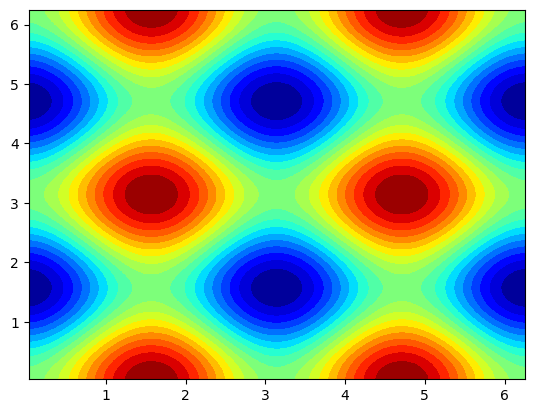

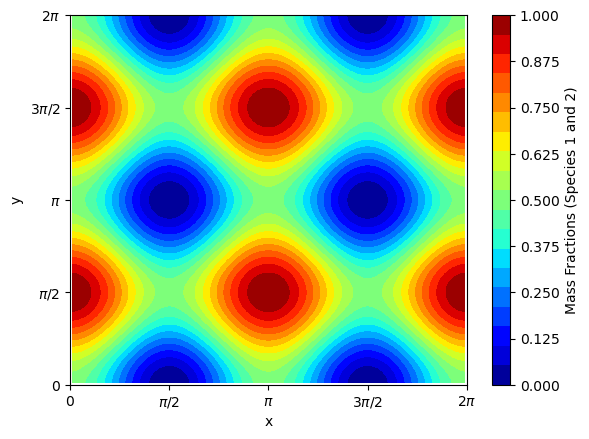

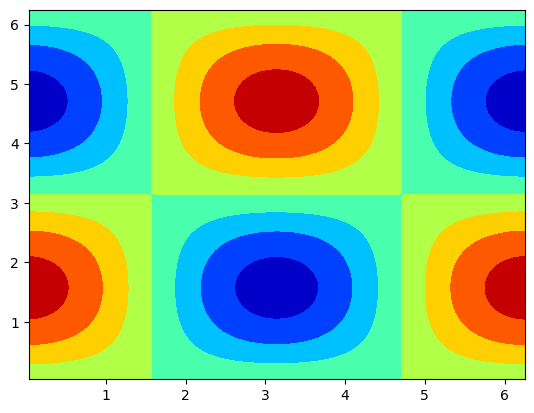

0.9990133642141359
0.9990133642141358
0.9982361788715112
0.9990152041427496
0.9974604692069262
0.9990160984534119
0.9966862329625036
0.9990160432128524
0.9959134679228925
0.999015034491624
0.9951421719152104
0.9990130683642564
0.9943723428089541
0.9990101409094051
0.9936039785158807
0.999006248209989
0.9928370769898572
0.9990013863533238
0.992071636226685
0.9989955514312465
0.9913076542638904
0.998988739540232
0.9905451291804925
0.9989809467815038
0.9897840590967413
0.998972169261136
0.9890244421738282
0.9989624030901496
0.9882662766135735
0.9989516443846003
0.9875095606580856
0.99893988926566
0.9867542925893963
0.9989271338596911
0.9860004707290726
0.9989133742983152
0.9852480934378027
0.9988986067184723
0.984497159114961
0.9988828272624768
0.9837476661981492
0.9988660320780652
0.9829996131627149
0.9988482173184373
0.98225299852125
0.9988293791422925
0.9815078208230672
0.9988095137138597
0.9807640786536564
0.9987886172029202
0.9800217706341211
0.9987666857848274
0.9792808954205953
0.9

<Figure size 640x480 with 0 Axes>

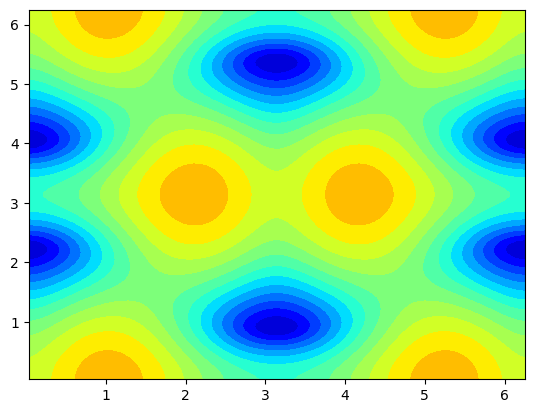

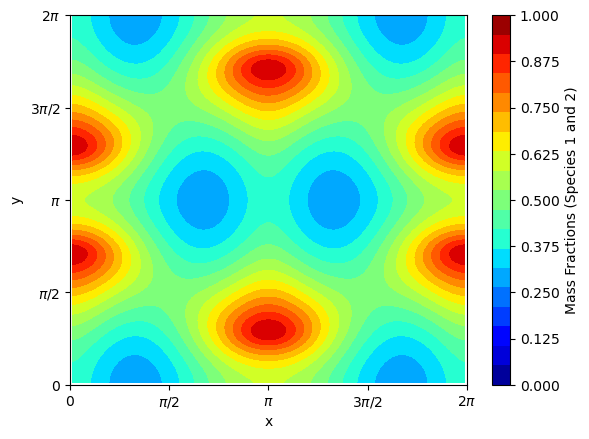

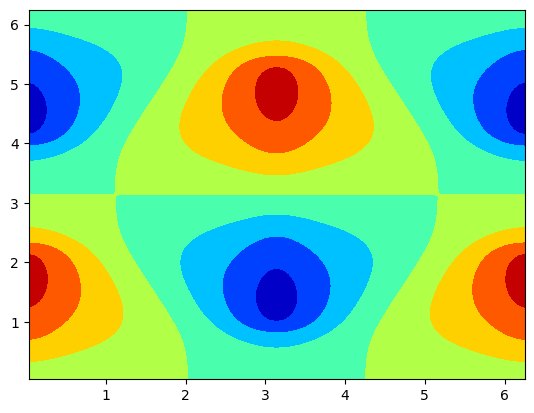

0.7194870668877272
0.9430029523412592
0.7193120360204401
0.9428182929900132
0.7191371412113112
0.9426315702613683
0.718962403758204
0.9424428099375362
0.7187878276431166
0.9422520200882698
0.7186134126438406
0.9420592044740758
0.71843915853406
0.9418643669770969
0.7182650650833615
0.9416675116004495
0.7180911320572447
0.9414686424675323
0.7179173592171322
0.9412677638213087
0.7177437463203772
0.9410648800235624
0.717570293120272
0.9408599955541257
0.7173969993660542
0.9406531150100822
0.7172238648029128
0.9404442431049446
0.7170508891719938
0.9402333846678054
0.7168780722104038
0.9400205446424654
0.7167054136512138
0.9398057280865355
0.7165329132234618
0.9395889401705151
0.7163605706521544
0.9393701861768481
0.7161883856582681
0.9391494714989534
0.716016357958749
0.9389268016402356
0.7158444872665125
0.9387021822130702
0.7156727732904419
0.9384756189377694
0.7155012157353857
0.9382471176415251
0.7153298143021554
0.9380166842573318
0.7151585686875213
0.9377843248228872
0.714987478584208

<Figure size 640x480 with 0 Axes>

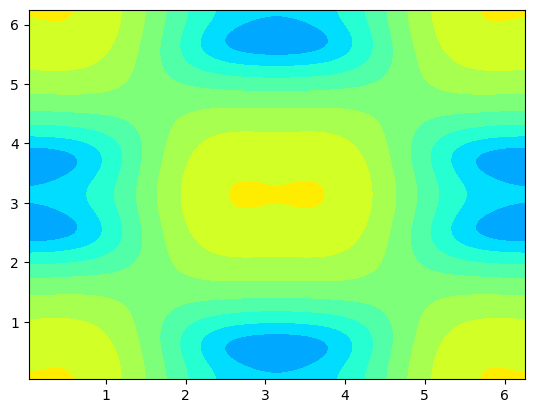

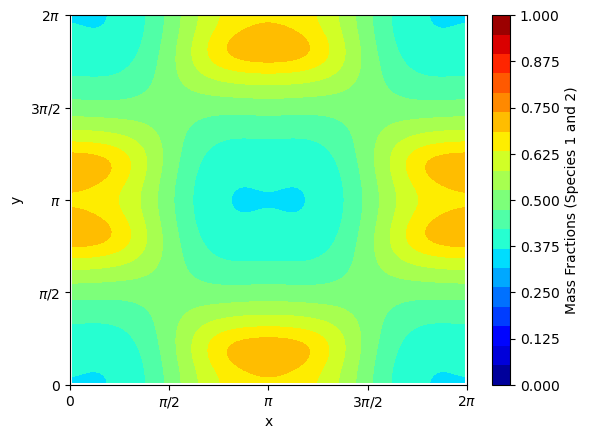

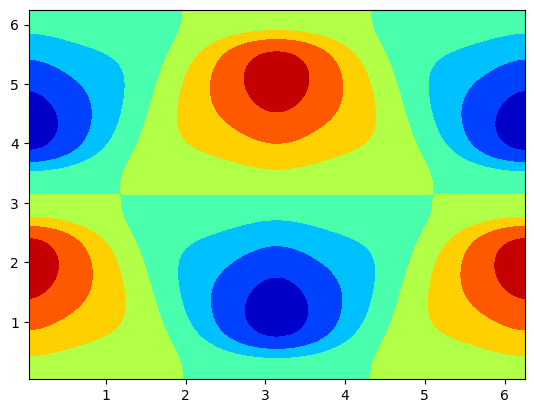

0.6339281795494711
0.7330807717007354
0.6338923826294631
0.7328755628924429
0.6338565316592392
0.7326702330656336
0.6338206266124428
0.7324647849404987
0.6337846674630095
0.7322592212398654
0.6337486541851948
0.7320535446887837
0.6337125867536006
0.7318477580141111
0.633676465143205
0.7316418639441001
0.6336402893293889
0.7314358652079861
0.6336040592879649
0.731229764535574
0.6335677749952057
0.731023564656828
0.6335314364278716
0.7308172683014618
0.6334950435632399
0.7306108781985285
0.6334585963791327
0.7304043970760135
0.6334220948539455
0.7301978276604278
0.6333855389666762
0.7299911726764037
0.6333489286969527
0.72978443484629
0.6333122640250624
0.7295776168897516
0.63327554493198
0.7293707215233696
0.6332387713993965
0.7291637514602425
0.6332019434097473
0.7289567094095908
0.6331650609462408
0.7287495980763641
0.6331281239928863
0.7285424201608482
0.6330911325345231
0.7283351783582773
0.6330540865568477
0.7281278753584467
0.6330169860464422
0.7279205138453292
0.6329798309908024


<Figure size 640x480 with 0 Axes>

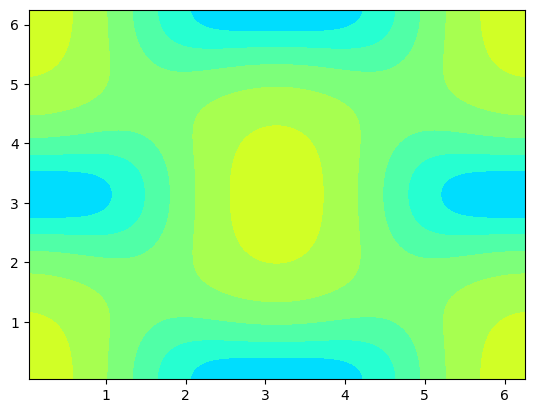

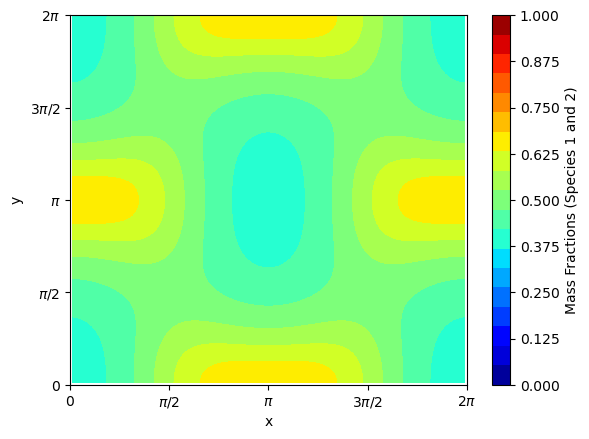

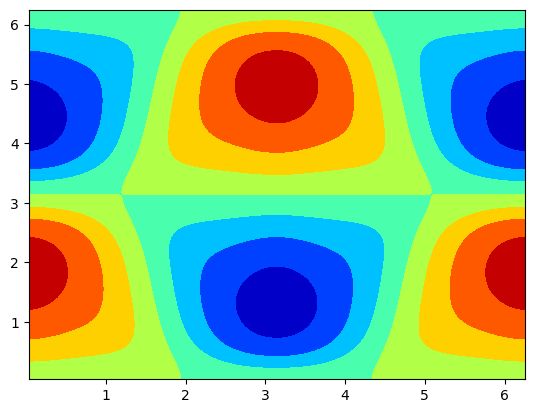

0.6060360355565217
0.6724914661283707
0.6059872148896635
0.672412286764364
0.6059383925614318
0.6723329787033961
0.6058895686696477
0.6722535422920399
0.6058407433100145
0.6721739778745608
0.6057919165761128
0.6720942857929082
0.6057430885593995
0.6720144663867063
0.6056942593492053
0.6719345199932476
0.6056454290327323
0.6718544469474869
0.6055965976950529
0.6717742475820357
0.6055477654191089
0.6716939222271596
0.6054989322857105
0.6716134712107745
0.6054500983735364
0.6715328948584454
0.6054012637591335
0.6714521934933861
0.6053524285169178
0.6713713674364601
0.6053035927191751
0.6712904170061814
0.6052547564360619
0.671209342518719
0.6052059201255433
0.6711281449363359
0.6051570839850423
0.6710468247925033
0.6051082480834488
0.6709653824088277
0.6050594124874998
0.6708838181045772
0.6050105772617818
0.6708021321966876
0.6049617424687324
0.6707203249997706
0.6049129081686433
0.6706383968261206
0.6048640744196628
0.670556347985725
0.6048152412777994
0.6704741787862752
0.6047664087969

<Figure size 640x480 with 0 Axes>

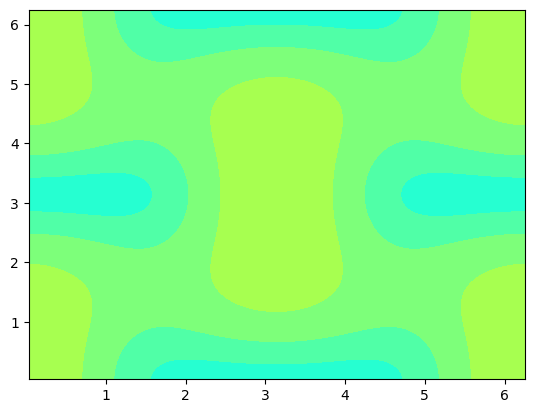

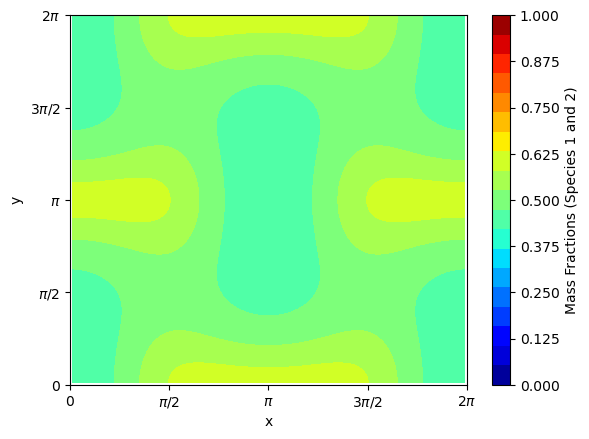

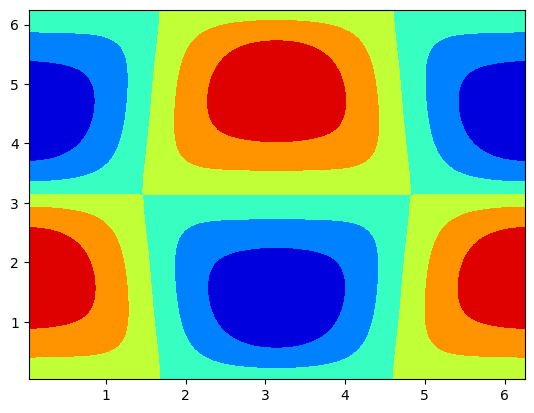

0.5698390349834228
0.6028755772531961
0.5697941750474983
0.6027986081255831
0.5697493235916457
0.6027216561120929
0.5697044805714913
0.6026447214081097
0.569659645943501
0.6025678042077118
0.569614819664988
0.6024909047036638
0.5695700016941186
0.6024140230874071
0.5695251919899215
0.6023371595490508
0.5694803908503355
0.6022603148572032
0.5694355983729124
0.6021834894337895
0.5693908145168136
0.6021066834604493
0.5693460392420631
0.6020298971173986
0.5693012725095531
0.6019531305834247
0.5692565142810515
0.6018763840358802
0.569211764519208
0.6017996576506769
0.5691670231875608
0.6017229516022814
0.5691222902505425
0.6016462660637101
0.5690775656734868
0.6015696012065241
0.569032849422634
0.6014929572008257
0.5689881414651371
0.6014163342152538
0.5689434417690674
0.6013397324169801
0.5688987503034205
0.6012631519717065
0.5688540670381211
0.6011865930436612
0.568809391944029
0.6011100557955956
0.5687647249929438
0.6010335403887825
0.5687200661576101
0.6009570469830132
0.568675415411722

<Figure size 640x480 with 0 Axes>

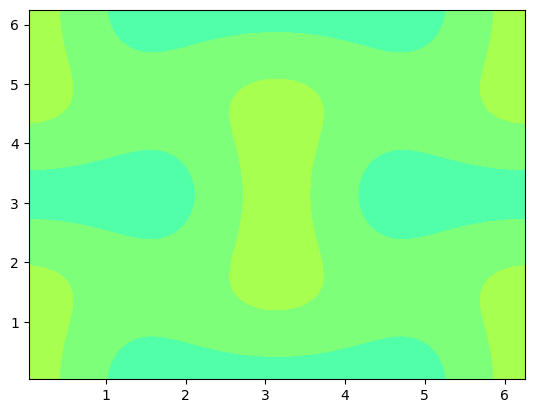

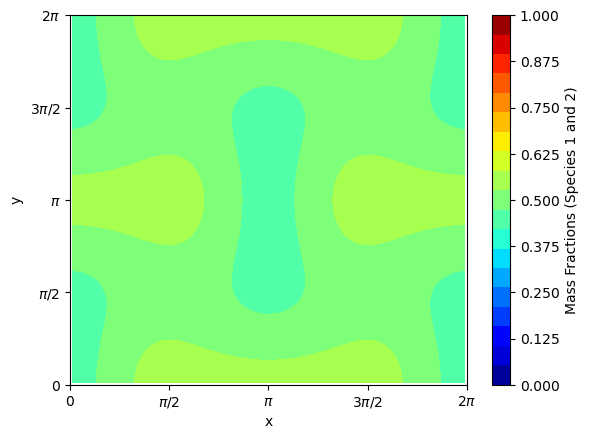

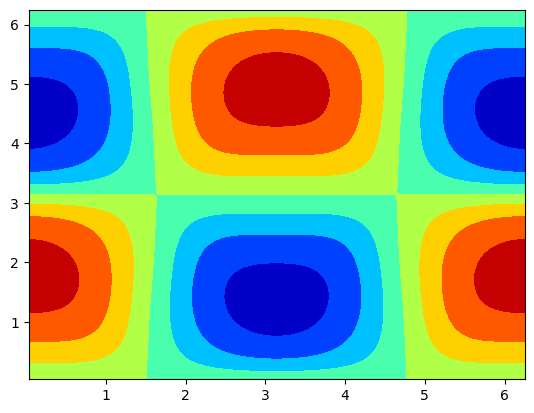

0.541683717309695
0.5586440395294648
0.5416556881586017
0.5585997145784046
0.5416276731005922
0.5585554086786918
0.5415996721533314
0.558511121820039
0.5415716853337169
0.5584668539923578
0.5415437126578768
0.558422605185765
0.5415157541411667
0.5583783753905869
0.541487809798167
0.5583341645973646
0.5414598796426805
0.5582899727968592
0.5414319636877305
0.5582457999800564
0.5414040619455576
0.558201646138171
0.5413761744276187
0.5581575112626519
0.5413483011445841
0.5581133953451861
0.5413204421063361
0.5580692983777039
0.5412925973219676
0.5580252203523823
0.5412647667997794
0.5579811612616491
0.5412369505472802
0.5579371210981879
0.5412091485711842
0.5578930998549414
0.54118136087741
0.5578490975251147
0.5411535874710803
0.55780511410218
0.5411258283565201
0.5577611495798795
0.5410980835372562
0.5577172039522291
0.5410703530160168
0.5576732772135213
0.5410426367947306
0.5576293693583293
0.5410149348745263
0.5575854803815092
0.540987247255733
0.5575416102782033
0.5409595739378794
0.5

<Figure size 640x480 with 0 Axes>

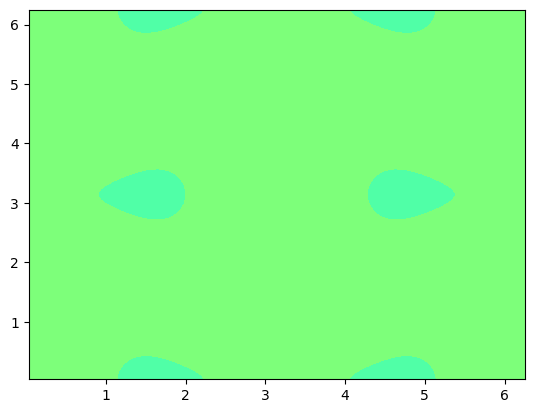

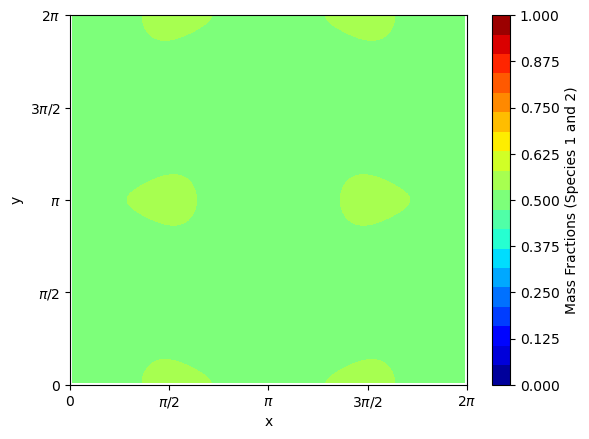

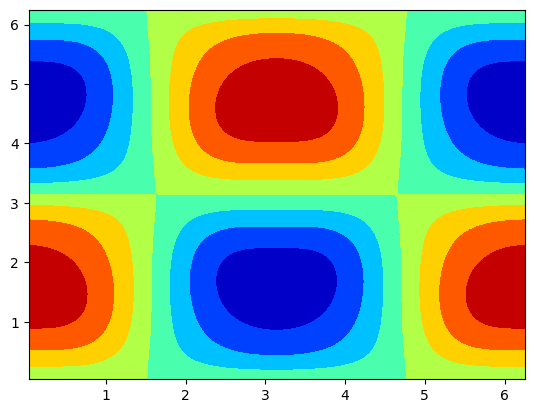

0.5251781946922865
0.5329785701935643
0.5251603779689732
0.5329522330137068
0.525142567270356
0.5329259117378666
0.5251247625929075
0.5328996063454844
0.5251069639334639
0.5328733168160305
0.5250891712892243
0.5328470431290081
0.5250713846577507
0.5328207852639548
0.5250536040369669
0.5327945432004438
0.5250358294251577
0.5327683169180863
0.5250180608209687
0.5327421063965326
0.5250002982234048
0.5327159116154744
0.5249825416318293
0.5326897325546458
0.5249647910459632
0.5326635691938261
0.5249470464658833
0.5326374215128397
0.5249293078920215
0.5326112894915596
0.5249115753251633
0.5325851731099074
0.5248938487664457
0.532559072347856
0.5248761282173567
0.5325329871854305
0.5248584136797327
0.5325069176027101
0.5248407051557571
0.532480863579829
0.5248230026479586
0.5324548250969791
0.524805306159209
0.53242880213441
0.5247876156927213
0.5324027946724317
0.5247699312520476
0.5323768026914151
0.5247522528410771
0.5323508261717943
0.5247345804640333
0.5323248650940674
0.5247169141254723

<Figure size 640x480 with 0 Axes>

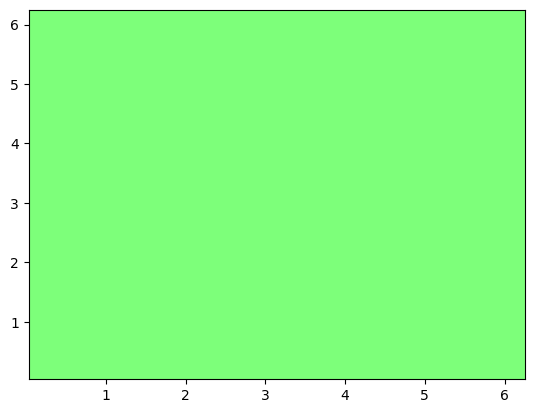

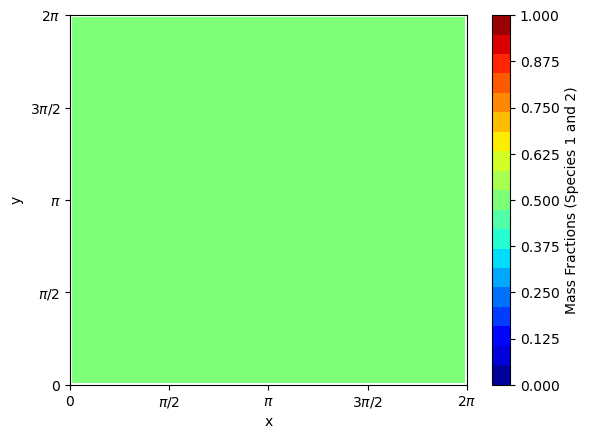

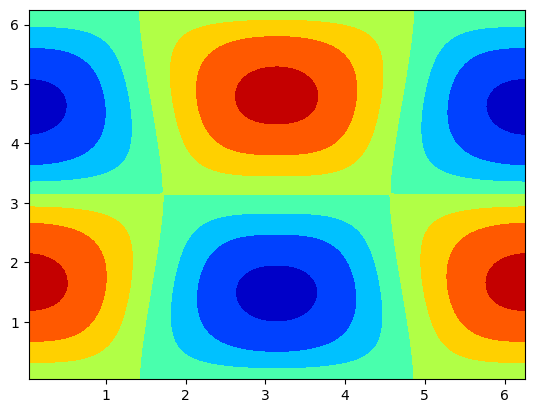

0.5147870064677293
0.5181156029829171
0.5147753734548486
0.5180998902267019
0.5147637479359659
0.5180841883281848
0.5147521299005865
0.5180684972845364
0.5147405193379816
0.5180528170929302
0.5147289162371912
0.5180371477505428
0.5147173205870258
0.5180214892545528
0.5147057323760674
0.5180058416021405
0.514694151592673
0.5179902047904866
0.5146825782249749
0.5179745788167729
0.5146710122608839
0.5179589636781806
0.5146594536880912
0.5179433593718902
0.51464790249407
0.517927765895081
0.5146363586660782
0.5179121832449305
0.51462482219116
0.5178966114186142
0.514613293056149
0.5178810504133045
0.5146017712476698
0.5178655002261708
0.5145902567521403
0.5178499608543793
0.5145787495557745
0.5178344322950914
0.5145672496445848
0.5178189145454648
0.514555757004384
0.517803407602652
0.5145442716207885
0.5177879114638002
0.5145327934792201
0.5177724261260513
0.5145213225649091
0.5177569515865412
0.5145098588628967
0.5177414878423998
0.5144984023580377
0.5177260348907501
0.5144869530350029
0.

<Figure size 640x480 with 0 Axes>

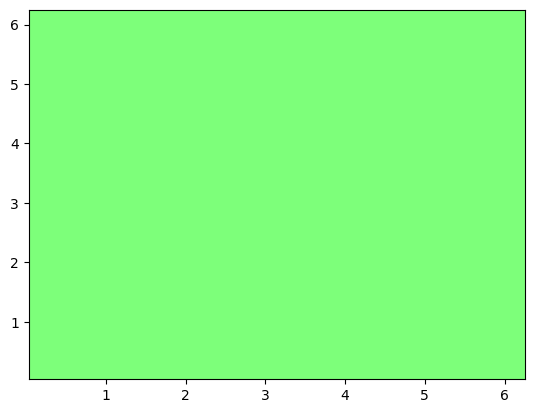

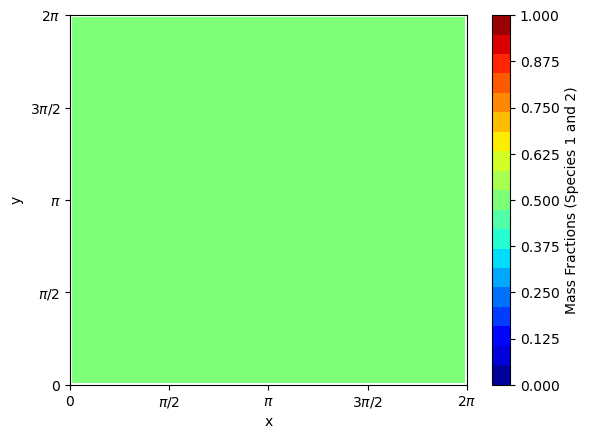

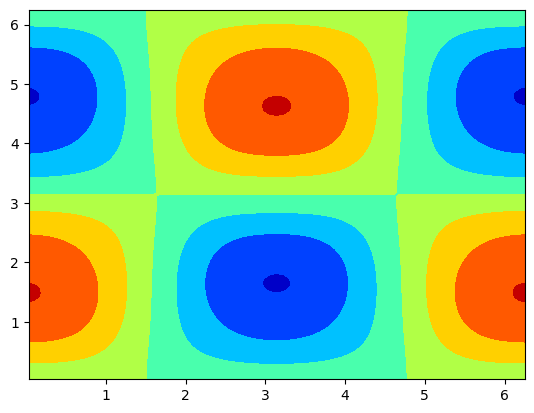

0.5084083289148283
0.5097211999961093
0.5084011846185973
0.5097123653550102
0.5083940444459244
0.50970353700515
0.5083869083970075
0.5096947149415857
0.5083797764721092
0.5096858991594757
0.5083726486715551
0.50967708965408
0.5083655249957341
0.5096682864207593
0.508358405445097
0.5096594894549756
0.5083512900201564
0.5096506987522915
0.5083441787214854
0.5096419143083702
0.5083370715497172
0.509633136118975
0.5083299685055442
0.5096243641799687
0.5083228695897177
0.509615598487315
0.5083157748030468
0.5096068390370758
0.5083086841463973
0.5095980858254132
0.508301597620692
0.5095893388485874
0.508294515226909
0.5095805981029576
0.5082874369660817
0.5095718635849813
0.508280362839297
0.5095631352912138
0.508273292847696
0.5095544132183077
0.5082662269924719
0.5095456973630137
0.50825916527487
0.5095369877221785
0.5082521076961871
0.5095282842927459
0.50824505425777
0.5095195870717557
0.5082380049610152
0.5095108960563435
0.5082309598073684
0.5095022112437401
0.508223918798323
0.5094935

KeyboardInterrupt: 

In [682]:
# Main Code
V, P, T, e, Y     = initial_condition_TGV(V, Y, V_0, P, P_0, rho_0, e, T, T_0, C_v, Nx, Ny, x, y, order)
current_time    = 0
iter            = 0     # Counter for simulation
i               = 0     # Counter for plotting

# Fill ghost cells
V = Ghost_Cells.fill_ghost_cells_2D(V, order)
P = Ghost_Cells.fill_ghost_cells_2D_single(P, order)
T = Ghost_Cells.fill_ghost_cells_2D_single(T, order)
Y = Ghost_Cells.fill_ghost_cells_2D_single(Y, order)
Q = get_Q_from_V(V, Q, order) # Get Q from V
Q = Ghost_Cells.fill_ghost_cells_2D(Q, order) # Fill ghost cells

overshoot       = False # Overshoot flags

# for plotting
KE          = []
Entrophy    = []
time        = []

while current_time < t_end and iter < iter_end:
 
    # # Calculate P, T and tau_xx, tau_yy, tau_xy = tau_yx
    T = EquationOfState.Temperature_from_internal_energy(e, C_v, order)
    P = EquationOfState.calculate_pressure_from_temperature(V, R_s, T, order) 
    
    dt      = Time_Step.dt_2D(V, mu, dx, dy, CFL, ngc, R_s, gamma, T)
    
    # Check overshooting of plot times, this ensures plot time to be exact
    if current_time + dt > plot_time[i]:
        # Take the smallest time step
        dt = plot_time[i] - current_time
        overshoot = True
                                        
    # First Derivatives
    dV_dx = FiniteDifference_2D.df_dx_2D(V, dx, order) 
    dV_dy = FiniteDifference_2D.df_dy_2D(V, dy, order)
    
    dT_dx = FiniteDifference_2D_single.df_dx_2D(T, dx, order)
    dT_dy = FiniteDifference_2D_single.df_dy_2D(T, dy, order)
    
    # Second Derivatives
    d2Dx_dx2   = FiniteDifference_2D.d2f_dx2_2D(Dx, dx, order)
    d2Dy_dy2   = FiniteDifference_2D.d2f_dy2_2D(Dy, dy, order)
  
    # Calculate tau
    tau, tau_xx, tau_yy, tau_xy, tau_yx = calculate_tau(tau, dV_dx, dV_dy, mu, order) # Calculate Tau

    # Get fluxes
    Cx, Cy = get_Convective_flux(V, Q, Cx, Cy, P, order) # Convective fluxes
    Dx, Dy = get_Diffusive_flux(V, Q, dT_dx, dT_dy, Dx, Dy, tau_xx, tau_yy, tau_xy, tau_yx, gamma, order) # Diffusive fluxes  
    
    dCx_dx     = FiniteDifference_2D.df_dx_2D(Cx, dx, order)
    dCy_dy     = FiniteDifference_2D.df_dy_2D(Cy, dy, order)
    
    dDx_dx     = FiniteDifference_2D.df_dx_2D(Dx, dx, order)
    dDy_dy     = FiniteDifference_2D.df_dy_2D(Dy, dy, order)  
                                                        
    # Time Integration for momentum  
    
    # Continuity equation for species 0
    Q[:,:, 0] += dt * (-(dCx_dx[:,:,0] + dCy_dy[:,:,0]) + dDx_dx[:,:,0] + dDy_dy[:,:,0])
    
    # Continuity equation for species 1
    Q[:,:, 4] += dt * (-(dCx_dx[:,:,4] + dCy_dy[:,:,4]) + dDx_dx[:,:,4] + dDy_dy[:,:,4])
    print(np.max(Y[ngc:-ngc, ngc:-ngc, 0]))
   # Y       = update_Y(Q, V)
    # Update ghost cells for new Q
    Q       = Ghost_Cells.fill_ghost_cells_2D(Q, order)
    
    V       = get_V_from_Q(Q, V, order) # Get V from Q
    print(np.max(Y[ngc:-ngc, ngc:-ngc, 1]))
    # x-dir momentum    
    Q[:,:, 1] += dt * (-(dCx_dx[:,:,1] + dCy_dy[:,:,1]) + dDx_dx[:,:,1] + dDy_dy[:,:,1]) 
    
    # y-dir momentum
    Q[:,:, 2] += dt * (-(dCx_dx[:,:,2] + dCy_dy[:,:,2]) + dDx_dx[:,:,2] + dDy_dy[:,:,2])
    
    # Energy equation
    Q[:,:, 3] += dt * (-(dCx_dx[:,:,3] + dCy_dy[:,:,3]) + dDx_dx[:,:,3] + dDy_dy[:,:,3])
    
    # OR
    # Q[:,:,:] += dt *(-(dCx_dx + dCy_dy) + dDx_dx + dDy_dy)
    # Update Y
    Y       = update_Y(Q, V)
    # Update ghost cells for new Q
    Q       = Ghost_Cells.fill_ghost_cells_2D(Q, order)
    
    V       = get_V_from_Q(Q, V, order) # Get V from Q
    
    # Internal energy from V
    e = V[:,:,3] - 0.5*(V[:,:,1]**2 + V[:,:,2]**2)
    e = Ghost_Cells.fill_ghost_cells_2D_single(e, order)
    
    # Vorticity Calculation
    dV_dx = FiniteDifference_2D.df_dx_2D(V, dx, order)
    dV_dy = FiniteDifference_2D.df_dy_2D(V, dy, order)
    vorticity = dV_dy[:,:,1] - dV_dx[:,:,2] 
    vorticity = Ghost_Cells.fill_ghost_cells_2D_single(vorticity, order) 
    
    
    # For plotting KE and Entropy vs time
    
    KE.append(0.5*np.mean(V[:,:,0]*(V[:,:,1]**2 + V[:,:,2]**2)))
    
    Entrophy.append(np.mean(vorticity**2))

    time.append(current_time)
    
    current_time    += dt       # Update time     
    iter            += 1        # Update iteration
    
    # If overshoot is true, plot   
    if overshoot == True:
        
        print(f"Current time: {current_time}, dt: {dt}, i: {i}, plot_time[i]: {plot_time[i]}")       
        
        # Plot the vorticity field
        #fig, ax = pyplot.subplots()
        pyplot.figure()


# Add colorbar and labels
        
        pyplot.figure()
        pyplot.contourf(X, Z, Y[ngc:-ngc, ngc:-ngc,0],cmap = "jet",levels = np.linspace(0,1,20))  
        pyplot.show()  
        pyplot.contourf(X, Z, Y[ngc:-ngc, ngc:-ngc,1],cmap = "jet",levels = np.linspace(0,1,20))
        
        cbar = pyplot.colorbar(label='Mass Fractions (Species 1 and 2)')  
        cbar.set_ticks(np.linspace(0,1,9)) 
        pyplot.xlabel('x')
        pyplot.ylabel('y')
        # #pyplot.colorbar(label='Mass Fraction')
        # #pyplot.clabel(c, inline=True, fontsize=8)
        # # Set x and y axis in terms of pi
        xticks = np.arange(0, 2 * np.pi + np.pi / 2, np.pi / 2)
        xtick_labels = ['0', '$\\pi/2$', '$\\pi$', '$3\\pi/2$', '$2\\pi$']
        pyplot.xticks(xticks, xtick_labels)
        pyplot.yticks(xticks, xtick_labels)
        # pyplot.title('Vorticity Field')
        pyplot.show()
        
        # u velocity
        # fig2 = pyplot.figure()
        pyplot.contourf(X, Z, V[ngc:-ngc, ngc:-ngc, 1])
        # pyplot.colorbar(ax2, label='u velocity')
        # pyplot.xlabel('x')
        # pyplot.ylabel('y')
        # pyplot.title('u velocity Field')
        pyplot.show()
        
        
        # If want to plot pressure and temp
        # New pressure and temperature from internal energy
        # P = EquationOfState.Pressure_from_internal_energy(V, e, gamma, order)
        # T = EquationOfState.Temperature_from_internal_energy(e, C_v, order)
          
        i += 1
        overshoot = False
        


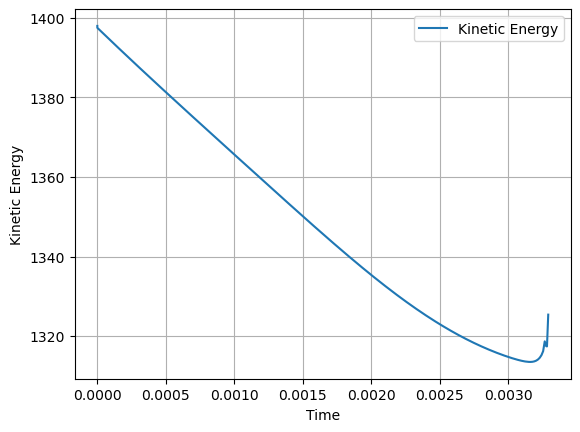

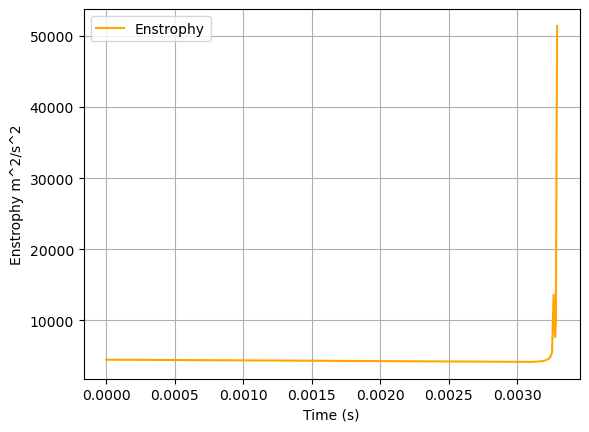

In [ ]:
pyplot.figure()
pyplot.plot(time, KE, label="Kinetic Energy")
pyplot.xlabel("Time")
pyplot.ylabel("Kinetic Energy")
# pyplot.title("Kinetic Energy vs Time")
pyplot.legend()
pyplot.grid()
pyplot.show()

pyplot.figure()
pyplot.plot(time, Entrophy, label="Enstrophy", color="orange")
pyplot.xlabel("Time (s)")
pyplot.ylabel("Enstrophy m^2/s^2")
# pyplot.title("Entrophy vs Time")
pyplot.legend()
pyplot.grid()
pyplot.show()

In [ ]:
# Save KE and time for the current run
run_id = "Res 100"  # Change this for each run
np.savetxt(f"KE_time_{run_id}.txt", np.column_stack((time, KE)), header="Time\tKinetic Energy", comments="", fmt="%.6f")

In [ ]:
# List of run identifiers
run_ids = ["Res 256", "Res 100"]  # Add all run IDs here

pyplot.figure()

# Loop through each run and plot its data
for run_id in run_ids:
    data = np.loadtxt(f"KE_time_{run_id}.txt", skiprows=1)
    time = data[:, 0]
    KE = data[:, 1]
    pyplot.plot(time, KE, label=f"Kinetic Energy ({run_id})")

# Add labels, legend, and grid
pyplot.xlabel("Time (s)")
pyplot.ylabel("Kinetic Energy (Joules)")
pyplot.legend()
pyplot.grid()
pyplot.show()

FileNotFoundError: KE_time_Res 256.txt not found.

<Figure size 640x480 with 0 Axes>